In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
%matplotlib inline
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from string import punctuation, digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn import metrics

In [4]:
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


In [5]:
df = pd.read_csv('drive/MyDrive/data/banki_all_responses.csv')
df.head()

,bank,url,responses_datetime,responses_header,responses_rating_grade,responses_status,responses_message,admin_username,admin_datetime,admin_answer,bank_username,bank_datetime,bank_answer
0,TalkBank,https://banki.ru/services/responses/bank/respo...,11.01.2021 13:11,получение карты,2.0,Проверяется,Попытался завести виртуальную карту - указал т...,NaN,NaN,NaN,NaN,NaN,NaN
1,TalkBank,https://banki.ru/services/responses/bank/respo...,02.01.2021 12:42,Накосячили и врут,1.0,Не засчитана,Заказал карту AdvCash эмитентом которой являет...,Администратор портала,05.01.2021 19:54,"Автор, уточните, пожалуйста, представитель как...",NaN,NaN,NaN
2,TalkBank,https://banki.ru/services/responses/bank/respo...,30.12.2020 14:50,Сервисом довольна,5.0,NaN,Друзья посоветовали завести виртуальную карту ...,Администратор портала,11.01.2021 12:39,"Спасибо за отзыв. Укажите, пожалуйста, как дол...",NaN,NaN,NaN
3,TalkBank,https://banki.ru/services/responses/bank/respo...,27.12.2020 19:01,Сервисы Talkbank,5.0,Не засчитана,Всю жизнь пытаюсь научиться контролировать сво...,Администратор портала,07.01.2021 15:23,"Спасибо за отзыв! Пришлите нам, пожалуйста, на...",NaN,NaN,NaN
4,TalkBank,https://banki.ru/services/responses/bank/respo...,21.12.2020 20:46,Использование карты за границей,5.0,NaN,Добрый день.Делюсь опытом использования карты ...,Администратор портала,30.12.2020 17:37,"Спасибо за отзыв. Направьте, пожалуйста, скрин...",NaN,NaN,NaN


## Анализ

In [ ]:
df['responses_status'].value_counts()[:20]

Не засчитана       174775
Проблема решена     61703
Проверяется          5590
Name: responses_status, dtype: int64

In [ ]:
# bank - название банка
# url - ссылка на отзыв 
# responses_datetime - датавремя отзыва 
# responses_header - заголовок отзыва
# responses_rating_grade - оценка 
# responses_status - статус отзыва
# responses_message - текст отзыва
# admin_username - имя админа.. 
# admin_datetime - дата ответа админа
# admin_answer  - текст ответа админа
# bank_username  -  имя банка.. чем отличается от первого столбца?? меньше значений, больше пропусков..
# bank_datetime  -  дата ответа банка
# bank_answer - текст ответа банка
columns = ['url']
df.drop(columns, inplace=True, axis=1)

In [ ]:
df.dtypes

bank                       object
responses_datetime         object
responses_header           object
responses_rating_grade    float64
responses_status           object
responses_message          object
admin_username             object
admin_datetime             object
admin_answer               object
bank_username              object
bank_datetime              object
bank_answer                object
dtype: object

In [ ]:
df.describe()

,responses_rating_grade
count,425556.000000
mean,2.373873
std,1.726301
min,1.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,5.000000


In [ ]:
categorical_columns= [column for column in df.columns if df[column].dtype == 'object']
numerical_columns = [column for column in df.columns if df[column].dtype != 'object']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630444 entries, 0 to 630443
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   bank                    630444 non-null  object 
 1   responses_datetime      626141 non-null  object 
 2   responses_header        630444 non-null  object 
 3   responses_rating_grade  425556 non-null  float64
 4   responses_status        242068 non-null  object 
 5   responses_message       626141 non-null  object 
 6   admin_username          326848 non-null  object 
 7   admin_datetime          324887 non-null  object 
 8   admin_answer            326802 non-null  object 
 9   bank_username           557429 non-null  object 
 10  bank_datetime           557429 non-null  object 
 11  bank_answer             562689 non-null  object 
dtypes: float64(1), object(11)
memory usage: 57.7+ MB


In [ ]:
# for column in categorical_columns:
#     print('Признак: {}, кол-во уникальных значений: {}'.format(column,df[column].nunique()))
#     print('Уникальные значения: ')
#     print(df[column].value_counts(), '\n')

In [ ]:
df['bank'].value_counts()[:20]

СберБанк                     98391
ВТБ                          73492
Альфа-Банк                   46381
Тинькофф Банк                45725
Банк Открытие                39580
Хоум Кредит Банк             25281
Совкомбанк                   24267
Почта Банк                   21139
Русский Стандарт             20623
Восточный Банк               18855
ОТП Банк                     14546
Ренессанс Кредит             11986
Московский Кредитный Банк    11689
Райффайзенбанк               11093
Росбанк                      10810
Россельхозбанк               10766
МТС Банк                     10635
Промсвязьбанк                10486
Траст                         8877
Кредит Европа Банк            8488
Name: bank, dtype: int64

2.1 Проверьте датасет на пропуски

пропусков очень много

In [ ]:
df.isna().sum()

bank                           0
responses_datetime          4303
responses_header               0
responses_rating_grade    204888
responses_status          388376
responses_message           4303
admin_username            303596
admin_datetime            305557
admin_answer              303642
bank_username              73015
bank_datetime              73015
bank_answer                67755
dtype: int64

2.2. Определите банки-лидеры по количеству зачтенных отзывов

In [ ]:
df['responses_status'].value_counts()

Не засчитана       174775
Проблема решена     61703
Проверяется          5590
Name: responses_status, dtype: int64

In [ ]:
df_filter = df['responses_status'].isin(['Проблема решена']) 
df22 = df[df_filter]

In [ ]:
df22[5:7]

,bank,responses_datetime,responses_header,responses_rating_grade,responses_status,responses_message,admin_username,admin_datetime,admin_answer,bank_username,bank_datetime,bank_answer
226,TalkBank,23.04.2019 16:10,Звонок по межгороду для разблокировки,3.0,Проблема решена,"Так получилось, что ошибочно ввел не тот код д...",Администратор портала,27.04.2019 13:23,"Спасибо за отзыв! Оценку принять не можем, так...",TalkBank,25.04.2019 10:16,Уважаемый Viktrok!Спасибо за отзыв! Нам очень ...
240,TalkBank,22.03.2019 10:34,Плохая работа поддержки,1.0,Проблема решена,15.03.2019 осуществил перевод физическому лицу...,NaN,NaN,NaN,TalkBank,22.03.2019 20:11,Уважаемый spv79!С момента вашего первого обращ...


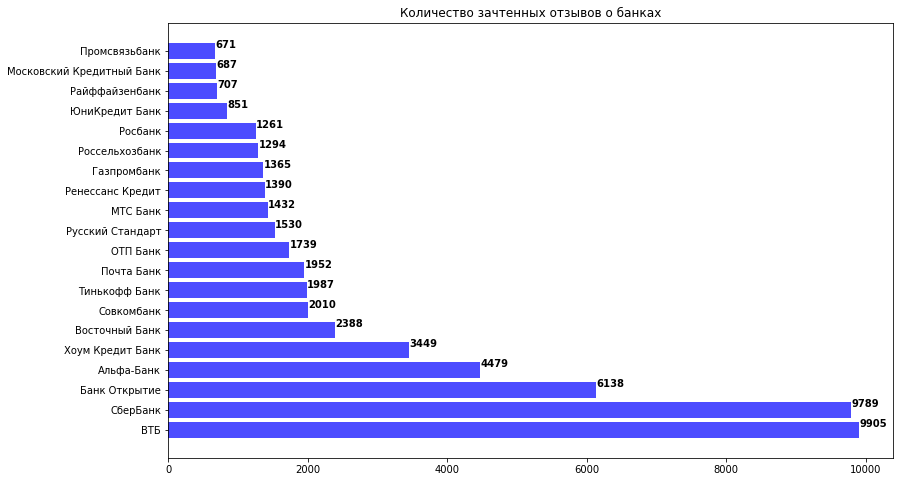

In [ ]:
counts = (df22['bank'].value_counts()[:20]).to_dict()
vv = list(counts.values())
kk = list(counts.keys())

fig, ax = plt.subplots(figsize=(13, 8)) 
ax.barh(kk, vv, alpha=0.7, color="blue")

plt.title('Количество зачтенных отзывов о банках')
for i, v in enumerate(vv):
    ax.text(v + 3, i + .15, str(v), fontweight='bold')
plt.show()

2.3. Проанализируйте динамику отзывов, ответов администраторов и банков

In [ ]:
df23 = df
ll = []
for i in df23['responses_datetime']:
  if type(i)==str: 
    ll.append(int(i[6:10])) 
  else:
    ll.append(math.nan)
df23['year'] = ll
df23.dropna(subset=['year'])
print('.')

.


In [ ]:
# counts = (df23['year'].value_counts()).to_dict()
# vv = list(counts.values())
# kk = list(counts.keys())

In [ ]:
# fig, ax = plt.subplots(figsize=(13, 8)) 
# ax.barh(kk, vv, alpha=0.7, color="lightgreen")

# plt.title('Количество отзывов о банках по годам')
# for i, v in enumerate(vv):
#     ax.text(v + 3, i + .15, str(v), fontweight='bold')
# plt.show()

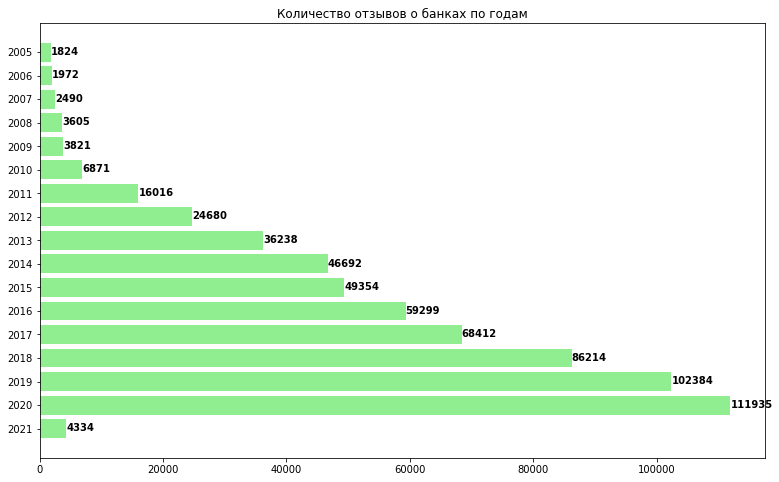

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8)) 
years = df23.year[df.year!=0].value_counts() 
 
plt.barh(years.index, years.values, color='lightgreen') 

ax.invert_yaxis()# от 2005 до 2021
plt.yticks(years.index)
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)), 
             fontsize=10, fontweight='bold') 

ax.set_title('Количество отзывов о банках по годам')
plt.show()

*С каждым годом количество отзывов пользователей увеличивается, спад в 2021 не учитывается, так как год еще не закончился *

Проанализируйте динамику изменения количества новых отзывов с 2006 по 2020 гг


Text(0.5, 1.0, 'Динамика изменения количества новых отзывов о банках по годам')

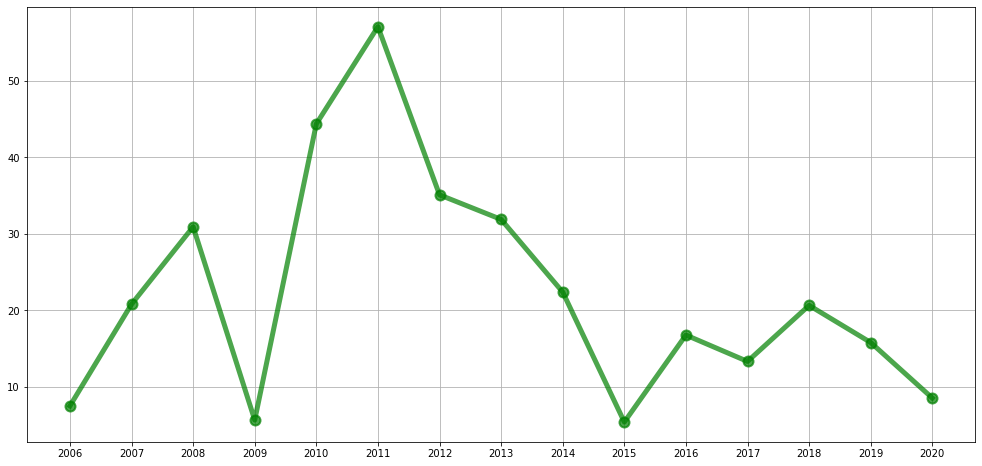

In [ ]:
years1 = df23.year[df.year!=2021].value_counts() 
new_resp1 = [i for i in years1.values]
new_resp1 = [(new_resp1[i]-new_resp1[i+1])/new_resp1[i]*100 for i in range(len(new_resp1)-1,)]

plt.figure(figsize=(17, 8))
plt.xticks(years1.index[:-1])
plt.grid() 
plt.plot(years1.index[:-1], new_resp1, 'o-g', alpha=0.7, label="first", lw=5, mew=2, ms=10)
ax.set_title('Динамика изменения количества новых отзывов о банках по годам')

Количество ответов администраторов на портале BANKI.RU по годам


In [ ]:
df24 = df
ll = []
for i in df24['admin_datetime']:
  if type(i)==str: 
    ll.append(int(i[6:10])) 
  else:
    ll.append(math.nan)
df24['year'] = ll
df24.dropna(subset=['year'])
print('.')

.


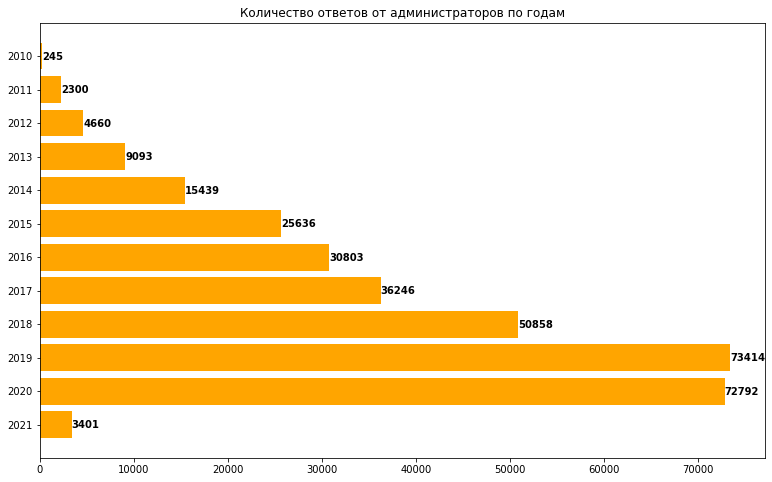

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8)) 
years = df24.year[df.year!=0].value_counts() 
 
plt.barh(years.index, years.values, color='orange') 

ax.invert_yaxis()# от 2005 до 2021
plt.yticks(years.index)
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)), 
             fontsize=10, fontweight='bold') 

ax.set_title('Количество ответов от администраторов по годам')
plt.show()

Динамика изменения количества ответов администраторов с 2006 по 2020 гг.


Text(0.5, 1.0, 'Динамика изменения количества ответов администраторов по годам')

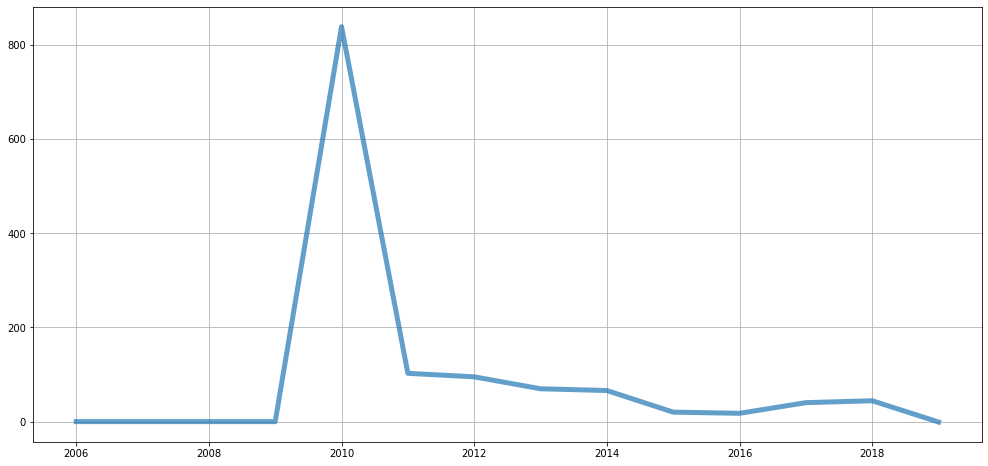

In [ ]:
years2 = df24.year[df.year!=2021].value_counts()
ff2 = pd.DataFrame()
ff2['y'] = years2.index
ff2['rew'] = years2.values
ff2 = ff2.sort_values(by = 'y').reset_index(level = 0)
new_resp2 = [0]*4+[(ff2['rew'][i+1] - ff2['rew'][i])/ff2['rew'][i]*100 for i in range(len(ff2['rew'])-1)]

plt.figure(figsize=(17, 8))
plt.grid() 
plt.plot([i for i in range(2006,2010)]+[i for i in ff2['y'][:-1]], new_resp2, alpha=0.7, lw=5, mew=2, ms=10)
ax.set_title('Динамика изменения количества ответов администраторов по годам')

Количество ответов банков на портале BANKI.RU по годам

In [ ]:
df25 = df
ll = []
for i in df25['bank_datetime']:
  if type(i)==str: 
    ll.append(i[6:10]) 
  else:
    ll.append(math.nan)
df25['year'] = ll
df25.dropna(subset=['year'])
print('.')

.


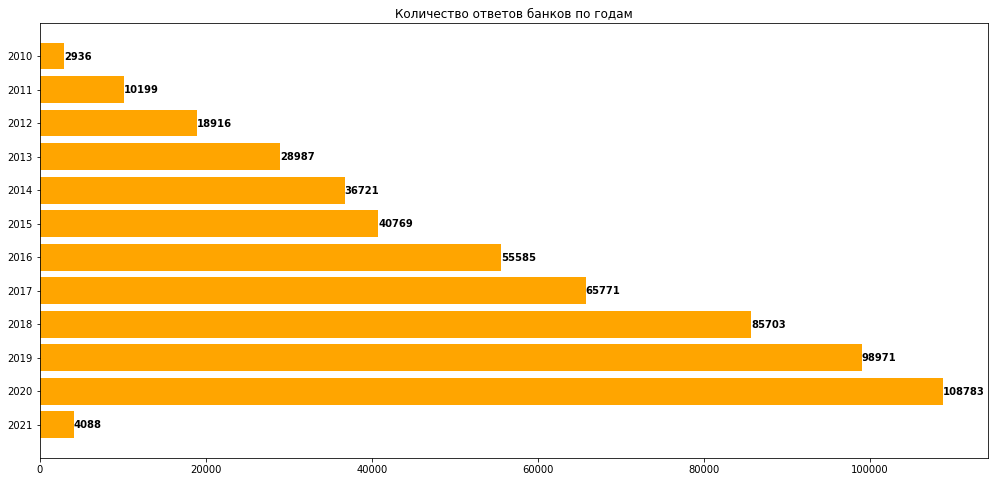

In [ ]:
fig, ax = plt.subplots(figsize=(17, 8)) 
years = df25.year[df.year!=0].value_counts()
years = years.reset_index(level = 0).sort_values(by = 'index')
 
plt.barh(years['index'], years['year'], color='orange') 

ax.invert_yaxis()# от 2005 до 2021
#plt.yticks(years.index)
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)), 
             fontsize=10, fontweight='bold') 

ax.set_title('Количество ответов банков по годам')
plt.show()

Text(0.5, 1.0, 'Динамика изменения количества ответов банков по годам')

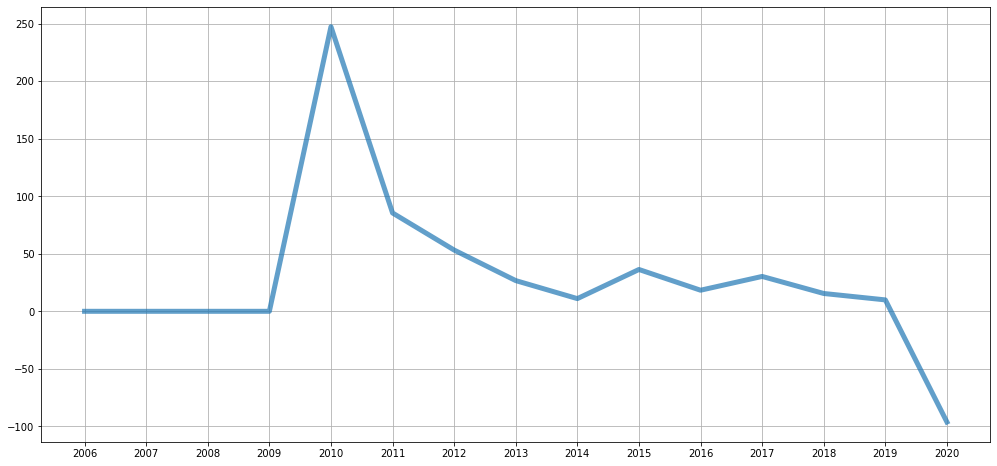

In [ ]:
years3 = df25.year[df.year!=0].value_counts()
ff3 = pd.DataFrame()
ff3['y'] = years3.index
ff3['rew'] = years3.values
ff3 = ff3.sort_values(by = 'y').reset_index(level = 0)
new_resp3 = [0]*4+[(ff3['rew'][i+1] - ff3['rew'][i])/ff3['rew'][i]*100 for i in range(len(ff3['rew'])-1)]

plt.figure(figsize=(17, 8))
#plt.xticks([i for i in range(2006,2010)]+[i for i in ff['y'][:-1]])
plt.grid() 
plt.plot([i for i in range(2006,2010)]+[i for i in ff3['y'][:-1]], new_resp3, alpha=0.7, lw=5, mew=2, ms=10)
ax.set_title('Динамика изменения количества ответов банков по годам')

Динамика изменения активности пользователей, администраторов и банков при написании работе с отзывами с 2006 по 2020 гг.

Text(0.5, 1.0, 'Динамика изменения количества ответов банков по годам')

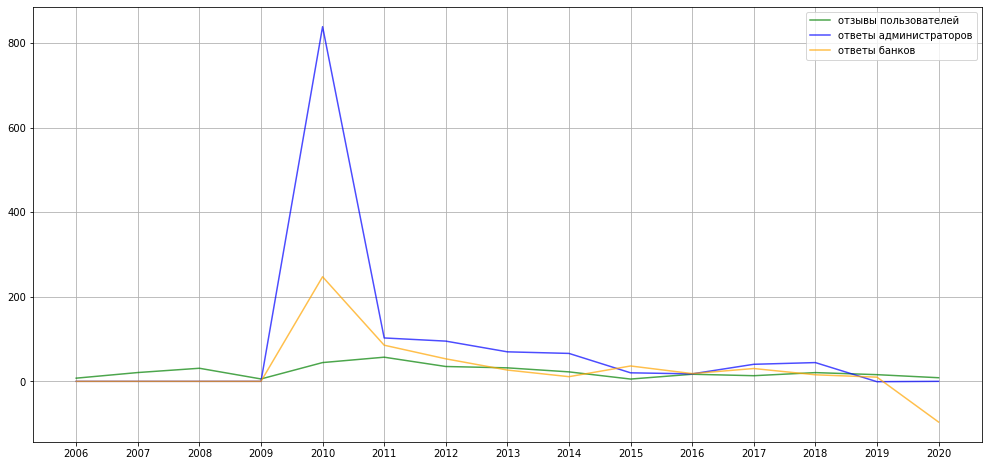

In [ ]:
plt.figure(figsize=(17, 8))
plt.xticks([i for i in range(2006,2010)]+[i for i in ff2['y'][:-1]]+[2020])
plt.grid() 
plt.plot([i for i in range(2006,2010)]+[i for i in ff2['y'][:-1]]+[2020], new_resp1[::-1],  label='отзывы пользователей', alpha=0.7, color = 'green')
plt.plot([i for i in range(2006,2010)]+[i for i in ff2['y'][:-1]]+[2020], new_resp2+[0], label='ответы администраторов', alpha=0.7, color = 'blue')
plt.plot([i for i in range(2006,2010)]+[i for i in ff2['y'][:-1]]+[2020], new_resp3, label='ответы банков', alpha=0.7, color='orange')

plt.legend(loc='best')
ax.set_title('Динамика изменения количества ответов банков по годам')

2010 год - количество отзывов и ответов (банков, администраторов) увеличивается максимально, а затем идёт постепенный спад, то есть количество отзывов и ответов все равно увеличивается (в процентах год от года), но с меньшей скоростью

Динамика изменения активности пользователей, администраторов и банков при написании работе с отзывами с 2015 по 2020 гг.

Text(0.5, 1.0, 'Динамика изменения количества ответов банков по годам')

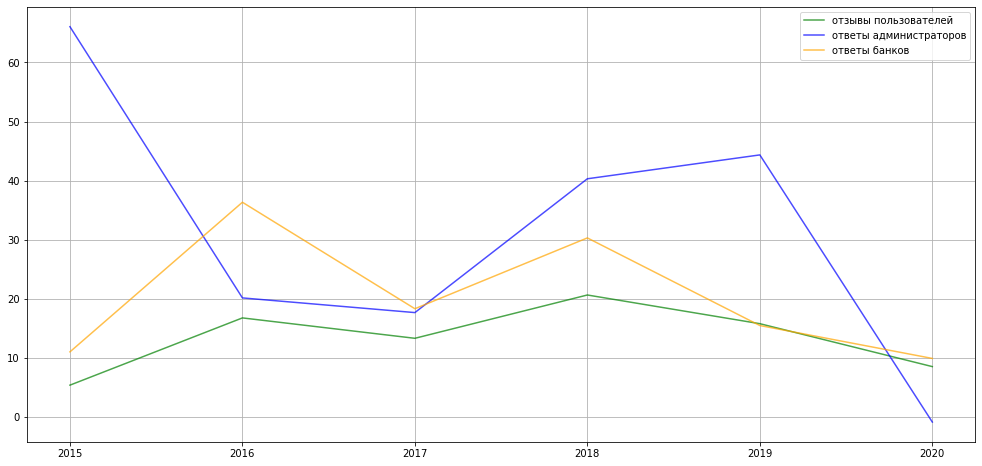

In [ ]:
plt.figure(figsize=(17, 8))
plt.xticks([i for i in range(2015,2021)])
plt.grid() 
plt.plot([i for i in range(2015,2021)], new_resp1[5::-1],  label='отзывы пользователей', alpha=0.7, color = 'green')
plt.plot([i for i in range(2015,2021)], new_resp2[8::], label='ответы администраторов', alpha=0.7, color = 'blue')
plt.plot([i for i in range(2015,2021)], new_resp3[8:-1], label='ответы банков', alpha=0.7, color='orange')

plt.legend(loc='best')
ax.set_title('Динамика изменения количества ответов банков по годам')

Распределение отзывов пользователей на BANKI.RU по статусу рассмотрения модераторами

Text(0.5, 1.0, 'Распределение отзывов пользователей на BANKI.RU по статусу рассмотрения модераторами')

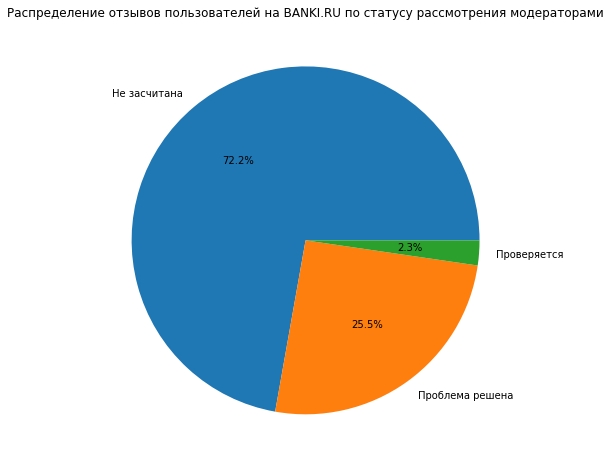

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
ww = df.responses_status[df.responses_status.notna()].value_counts() 
 
plt.pie( ww.values, labels = ww.index, autopct='%1.1f%%') 
plt.title('Распределение отзывов пользователей на BANKI.RU по статусу рассмотрения модераторами')

Категория "Проверяется" не обязательна при обучении, так как подразумевается, что после проверки эелементы данной категории попадут в другие категории (Проблема решена или не засчитана)

Распределение оценок отзывов в зависимости от статуса модерации BANKI.RU


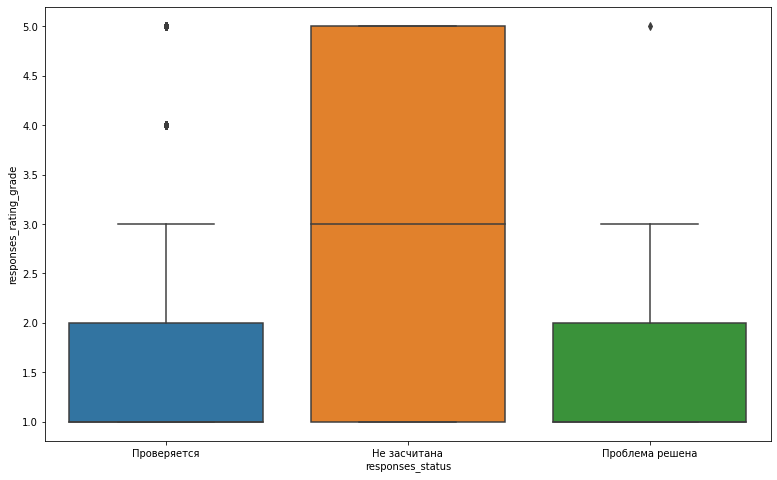

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.boxplot(x='responses_status', y='responses_rating_grade', data=df)

Среднее и медиана скорости ответа банка в зависимости от оценки клиента


In [ ]:
from datetime import datetime

def days_between(d1, d2):
  d1 = datetime.strptime(d1, "%d.%m.%Y %H:%M")
  d2 = datetime.strptime(d2, "%d.%m.%Y %H:%M")
  return abs((d2 - d1).days)

In [ ]:
df26 = df
df26.dropna(subset=['responses_datetime'])
df26.dropna(subset=['bank_datetime'])
ll = []
for i in range(0,len(df26['responses_datetime'])):
  if type(df26['responses_datetime'][i])==str and type(df26['bank_datetime'][i])==str:
    ll.append(days_between(df26['bank_datetime'][i], df26['responses_datetime'][i]))
  else:
    ll.append(0)

df26['speed_days'] = ll
df26.dropna(subset=['speed_days'])
print('.')

.


In [ ]:
import statistics
res26mean = []
res26median = []
for i in range(1,6):
  gr1 = (df26['speed_days'][df.responses_rating_grade==i]).to_dict()
  res26mean.append(statistics.mean(list(gr1.values())))
  res26median.append(statistics.median(list(gr1.values())))

Text(0.5, 1.0, 'Среднее и медиана скорости ответа банка в зависимости от оценки клиента')

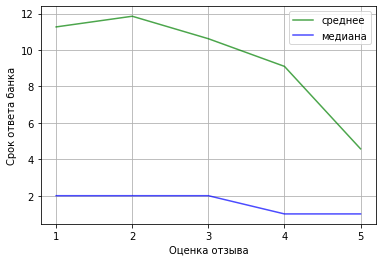

In [ ]:
plt.figure(figsize=(6, 4))
plt.grid() 
plt.xticks([i for i in range(1,6)])
plt.plot([i for i in range(1,6)], res26mean,  label='среднее', alpha=0.7, color = 'green')
plt.plot([i for i in range(1,6)], res26median, label='медиана', alpha=0.7, color = 'blue')

plt.legend(loc='best')
plt.xlabel("Оценка отзыва")
plt.ylabel("Срок ответа банка")
ax.set_title('Среднее и медиана скорости ответа банка в зависимости от оценки клиента')

Распределение оценок отзывов в зависимости от скорости ответа (до 30 дней)

In [ ]:
df26 = df26[df26.speed_days<30]

Text(0, 0.5, 'Срок ответа банка')

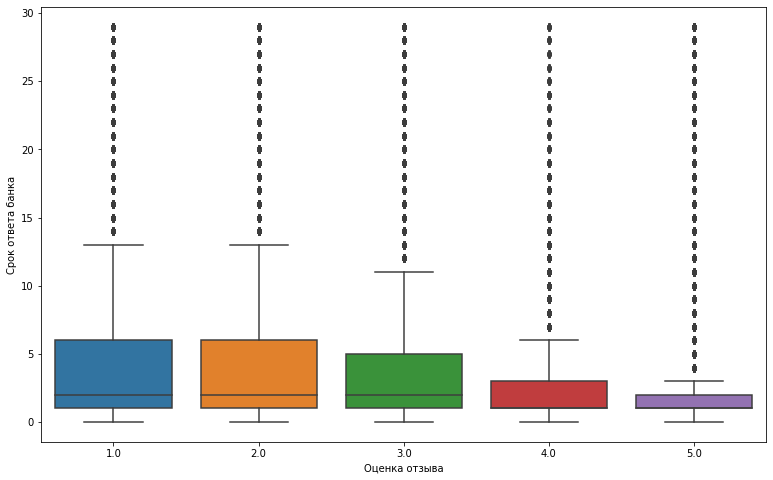

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.boxplot(x='responses_rating_grade', y='speed_days', data=df26)
plt.xlabel("Оценка отзыва")
plt.ylabel("Срок ответа банка")

## Обработка, модели

In [6]:
df['admin_answer'].value_counts()

В данной ситуации - без оценки.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      21682
Без оценки.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [7]:
df = df.dropna(subset=['responses_message'])
df.head()

,bank,url,responses_datetime,responses_header,responses_rating_grade,responses_status,responses_message,admin_username,admin_datetime,admin_answer,bank_username,bank_datetime,bank_answer
0,TalkBank,https://banki.ru/services/responses/bank/respo...,11.01.2021 13:11,получение карты,2.0,Проверяется,Попытался завести виртуальную карту - указал т...,NaN,NaN,NaN,NaN,NaN,NaN
1,TalkBank,https://banki.ru/services/responses/bank/respo...,02.01.2021 12:42,Накосячили и врут,1.0,Не засчитана,Заказал карту AdvCash эмитентом которой являет...,Администратор портала,05.01.2021 19:54,"Автор, уточните, пожалуйста, представитель как...",NaN,NaN,NaN
2,TalkBank,https://banki.ru/services/responses/bank/respo...,30.12.2020 14:50,Сервисом довольна,5.0,NaN,Друзья посоветовали завести виртуальную карту ...,Администратор портала,11.01.2021 12:39,"Спасибо за отзыв. Укажите, пожалуйста, как дол...",NaN,NaN,NaN
3,TalkBank,https://banki.ru/services/responses/bank/respo...,27.12.2020 19:01,Сервисы Talkbank,5.0,Не засчитана,Всю жизнь пытаюсь научиться контролировать сво...,Администратор портала,07.01.2021 15:23,"Спасибо за отзыв! Пришлите нам, пожалуйста, на...",NaN,NaN,NaN
4,TalkBank,https://banki.ru/services/responses/bank/respo...,21.12.2020 20:46,Использование карты за границей,5.0,NaN,Добрый день.Делюсь опытом использования карты ...,Администратор портала,30.12.2020 17:37,"Спасибо за отзыв. Направьте, пожалуйста, скрин...",NaN,NaN,NaN


In [8]:
df['responses_status'].value_counts()

Не засчитана       173767
Проблема решена     61233
Проверяется          5557
Name: responses_status, dtype: int64

In [9]:
df['responses_status'] = df.responses_status.map({ np.nan:0, 'Не засчитана':1, 'Проблема решена':2, 'Проверяется':3}) 

In [10]:
df['responses_status'].value_counts()

0    385584
1    173767
2     61233
3      5557
Name: responses_status, dtype: int64

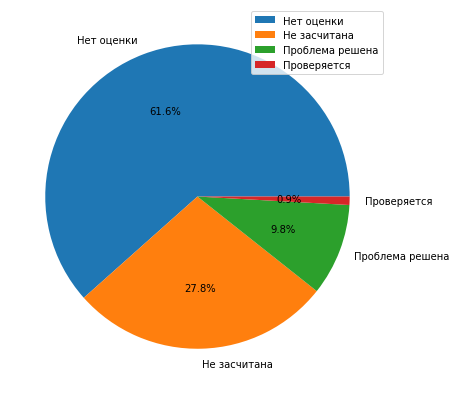

In [11]:
labels = ['Нет оценки', 'Не засчитана', 'Проблема решена', 'Проверяется']
x = [385584, 173767, 61233, 5557] 
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(x, labels=labels, explode = (0, 0,0,0),autopct='%1.1f%%')
ax1.legend(loc='best')
plt.show()

In [12]:
df_class_0 = df[df['responses_status'] == 0]
df_class_1 = df[df['responses_status'] == 1]
df_class_2 = df[df['responses_status'] == 2]
df_class_3 = df[df['responses_status'] == 3]
class_0 = df_class_0.sample(61233)
class_1 = df_class_1.sample(61233)
class_2 = df_class_2.sample(61233)

При обучении модели используются только категории НЕ ЗАСЧИТАНА и ПРОБЛЕМА РЕШЕНА

In [14]:
dff = pd.concat([class_1, class_2],axis=0)

In [15]:
dff['responses_status'].value_counts()

2    61233
1    61233
Name: responses_status, dtype: int64

In [16]:
dff.head()

,bank,url,responses_datetime,responses_header,responses_rating_grade,responses_status,responses_message,admin_username,admin_datetime,admin_answer,bank_username,bank_datetime,bank_answer
72819,Райффайзенбанк,https://banki.ru/services/responses/bank/respo...,29.01.2020 22:25,Благодарность,5.0,1,Хочу выразить особую благодарность К-ой Виктор...,Администратор портала,06.02.2020 12:21,"Спасибо за отзыв. Уточните, о каких трудностях...",Райффайзенбанк,30.01.2020 11:09,Добрый день.Благодарим Вас за тёплые слова в а...
441954,Альфа-Банк,https://banki.ru/services/responses/bank/respo...,28.05.2014 19:09,Служба взыскания достала,1.0,1,Добрый день! Год назад я взяла потребительский...,NaN,NaN,NaN,Альфа-Банк,29.05.2014 14:52,"Уважаемый Клиент,в связи с возникновением прос..."
148264,ВТБ,https://banki.ru/services/responses/bank/respo...,30.05.2014 19:05,Хорошему сотруднику,5.0,1,Есть такой выездной специалист как П-ная Ларис...,NaN,NaN,NaN,ВТБ,02.06.2014 11:59,"Добрый день, уважаемый alecsegik1991!Ваши тепл..."
302657,Банк Открытие,https://banki.ru/services/responses/bank/respo...,30.09.2020 10:00,Большое спасибо сотруднику банка за помощь!,5.0,1,После смены телефона возникли проблемы с прило...,Администратор портала,19.10.2020 14:16,"Почему вы выбрали именно этот банк, какими усл...",Банк Открытие,30.09.2020 10:12,"Добрый день.Большое спасибо, что нашли время и..."
78816,Райффайзенбанк,https://banki.ru/services/responses/bank/respo...,19.12.2014 0:17,Ознакомтесь,2.0,1,Сижу. Думаю. Переведу свой рублевый семизначны...,Администратор портала,22.12.2014 1:16,Насайте банканами обнаружено только одно отдел...,NaN,NaN,NaN


In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def tokenizzz(file_text):
  file_text = re.sub(r'(\W)\1{2,}', r'\1', file_text) 
  file_text = re.sub(r'(\w)\1{2,}', r'\1\1', file_text)
  file_text = re.sub(r'(?P<url>https?://[^\s]+)', '', file_text) 
  file_text = re.sub(r"\@(\w+)", '', file_text) 
  file_text = re.sub(r"\#(\w+)", '', file_text) 
  file_text = re.sub(r"\$(\w+)", '', file_text) 
  file_text = file_text.replace("-",' ')
  tokens = word_tokenize(file_text)
  tokens = [i for i in tokens if (i not in string.punctuation)] # удаляем знаки преп 

  stop_words = stopwords.words('russian')
  stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в','далее','которого','...','..','``','*'])
  tokens = [i.lower() for i in tokens if (i.lower() not in stop_words)]

  remove_digits = str.maketrans('', '', digits)
  tokens = [i.translate(remove_digits) for i in tokens]

  return ' '.join(tokens)

In [19]:
#tokenizzz(dff['responses_message'][573622])

In [20]:
dff['responses_message'] = dff['responses_message'].apply(tokenizzz) # обработка текста
dff.head()

,bank,url,responses_datetime,responses_header,responses_rating_grade,responses_status,responses_message,admin_username,admin_datetime,admin_answer,bank_username,bank_datetime,bank_answer
72819,Райффайзенбанк,https://banki.ru/services/responses/bank/respo...,29.01.2020 22:25,Благодарность,5.0,1,хочу выразить особую благодарность ой виктории...,Администратор портала,06.02.2020 12:21,"Спасибо за отзыв. Уточните, о каких трудностях...",Райффайзенбанк,30.01.2020 11:09,Добрый день.Благодарим Вас за тёплые слова в а...
441954,Альфа-Банк,https://banki.ru/services/responses/bank/respo...,28.05.2014 19:09,Служба взыскания достала,1.0,1,добрый день год назад взяла потребительский кр...,NaN,NaN,NaN,Альфа-Банк,29.05.2014 14:52,"Уважаемый Клиент,в связи с возникновением прос..."
148264,ВТБ,https://banki.ru/services/responses/bank/respo...,30.05.2014 19:05,Хорошему сотруднику,5.0,1,выездной специалист п ная лариса которая приез...,NaN,NaN,NaN,ВТБ,02.06.2014 11:59,"Добрый день, уважаемый alecsegik1991!Ваши тепл..."
302657,Банк Открытие,https://banki.ru/services/responses/bank/respo...,30.09.2020 10:00,Большое спасибо сотруднику банка за помощь!,5.0,1,смены телефона возникли проблемы приложением б...,Администратор портала,19.10.2020 14:16,"Почему вы выбрали именно этот банк, какими усл...",Банк Открытие,30.09.2020 10:12,"Добрый день.Большое спасибо, что нашли время и..."
78816,Райффайзенбанк,https://banki.ru/services/responses/bank/respo...,19.12.2014 0:17,Ознакомтесь,2.0,1,сижу думаю переведу свой рублевый семизначный ...,Администратор портала,22.12.2014 1:16,Насайте банканами обнаружено только одно отдел...,NaN,NaN,NaN


In [21]:
dff.isna().sum()

bank                          0
url                           0
responses_datetime            0
responses_header              0
responses_rating_grade        0
responses_status              0
responses_message             0
admin_username            67836
admin_datetime            67919
admin_answer              67846
bank_username              8528
bank_datetime              8528
bank_answer                8304
dtype: int64

In [22]:
X = dff['responses_message']
y = dff['responses_status']

In [25]:
X_train1, X_test1, y_train, y_test = train_test_split(X, y,  test_size = 0.3)
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)
cv = CountVectorizer()
cv.fit(X_train1)

X_train = cv.transform(X_train1)
X_train
X_test = cv.transform(X_test1)

(85726,)
(36740,)
(85726,)
(36740,)


In [32]:
len(cv.vocabulary_)

189473

Модели

1

In [26]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

[[12710  5516]
 [ 1877 16637]]
              precision    recall  f1-score   support

           1       0.87      0.70      0.77     18226
           2       0.75      0.90      0.82     18514

    accuracy                           0.80     36740
   macro avg       0.81      0.80      0.80     36740
weighted avg       0.81      0.80      0.80     36740



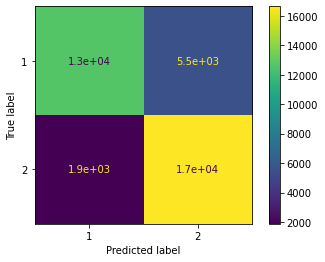

In [27]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
plot_confusion_matrix(clf,X_test,y_test)

In [28]:
a1 = metrics.accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print('Accuracy',a1)
print('F1-score',f1)

Accuracy 0.7987751769188894
F1-score 0.774692957059702


2

In [29]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

[[12662  5564]
 [ 5314 13200]]
              precision    recall  f1-score   support

           1       0.70      0.69      0.70     18226
           2       0.70      0.71      0.71     18514

    accuracy                           0.70     36740
   macro avg       0.70      0.70      0.70     36740
weighted avg       0.70      0.70      0.70     36740



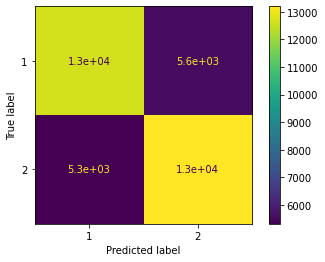

In [30]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
plot_confusion_matrix(clf,X_test,y_test)

In [31]:
a2 = metrics.accuracy_score(y_test, predictions)
f2 = f1_score(y_test, predictions)

print('Accuracy',a2)
print('F1-score',f2)

Accuracy 0.7039194338595536
F1-score 0.6995193635710735


3

In [33]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[14446  3780]
 [ 3962 14552]]
              precision    recall  f1-score   support

           1       0.78      0.79      0.79     18226
           2       0.79      0.79      0.79     18514

    accuracy                           0.79     36740
   macro avg       0.79      0.79      0.79     36740
weighted avg       0.79      0.79      0.79     36740



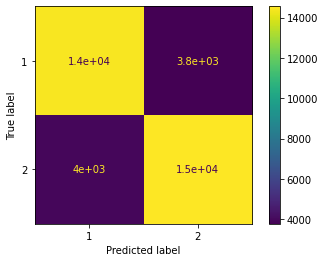

In [34]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
plot_confusion_matrix(clf,X_test,y_test)

In [35]:
a3 = metrics.accuracy_score(y_test, predictions)
f3 = f1_score(y_test, predictions)

print('Accuracy',a3)
print('F1-score',f3)

Accuracy 0.7892759934676102
F1-score 0.7886662663099853


### Result

In [39]:
res_mod1 = pd.DataFrame(index=['Naive Bayes','Decision tree','Logistic regression'])
res_mod1['Accuracy'] = [a1,a2,a3]
res_mod1['F1'] = [f1,f2,f3]
res_mod1

,Accuracy,F1
Naive Bayes,0.798775,0.774693
Decision tree,0.703919,0.699519
Logistic regression,0.789276,0.788666
